# Project: Write a data science blog post

In this project, the dataset for Airbnb rental listings for 2016 will be analyzed. Summary of findings from this notebook are published in [Medium](https://medium.com/@nikoladjor/udacity-data-science-nanodegree-analysis-of-seattle-airbnb-dataset-3c3d31b07d76) article.

## Business Understanding

The questions I wanted to study and engage community to comment and discuss are following:
- What are the busiest periods in Seattle and in which areas?
- What are the average prices for rentals on Airbnb and what are the most expensive areas?
- Price prediction with scikit-learn.

In [4]:
# Module imports

import numpy as np
import os
import sys
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import geopandas
import calendar
from mpl_toolkits.axes_grid1 import make_axes_locatable

%matplotlib inline

## Data Understanding and Data Prepare

### Gather Data

In [19]:
data_path = r'./data/kaggle_seattle_airbnb_2017/' 


calendar_df = pd.read_csv(data_path + 'calendar.csv')
listings_df = pd.read_csv(data_path + 'listings.csv')
reviews_df = pd.read_csv(data_path + 'reviews.csv')

neighbourhoods_info = pd.read_csv(data_path + 'neighbourhoods.csv')
neighbourhoods_df = geopandas.read_file(data_path + 'neighbourhoods.geojson')

### Calendar Dataset
Calendar dataframe holds the data about the availability and the prices for the listings at different dates.
If the listing is booked (`available == 'f'`), then the price should be `NaN`

In [20]:
calendar_df.head()

,listing_id,date,available,price
0,241032,2016-01-04,t,$85.00
1,241032,2016-01-05,t,$85.00
2,241032,2016-01-06,f,NaN
3,241032,2016-01-07,f,NaN
4,241032,2016-01-08,f,NaN


In [21]:
calendar_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1393570 entries, 0 to 1393569
Data columns (total 4 columns):
 #   Column      Non-Null Count    Dtype 
---  ------      --------------    ----- 
 0   listing_id  1393570 non-null  int64 
 1   date        1393570 non-null  object
 2   available   1393570 non-null  object
 3   price       934542 non-null   object
dtypes: int64(1), object(3)
memory usage: 42.5+ MB


### `calendar_df` cleanup
Since the `calendar_df` is dataframe with clear time-series, it is obvious that we should re-format the date. Also, it would be good to format 't' and 'f' to Boolean `True/False`, and prices to float.

I like to keep the listing id to `int64` for now.

As for the prices column, if I keep it to `NaN`, it would indicate the missing value, which is not true, the point is that this needs to be used along the availability column. This is why I will replace `NaN` with 0. That way, the calculation for the average price will not be influenced.

In [22]:
# Use pandas to get the datetime
tmp_date_fmt = pd.DatetimeIndex(calendar_df['date'])
# tmp_day = tmp_date_fmt.day
calendar_df['month'] = tmp_date_fmt.month
calendar_df['year'] = tmp_date_fmt.year

calendar_df['price'] = calendar_df['price'].apply( lambda x: np.float32(x.replace(',','').split('$')[1]) if type(x) == str else 0 )
calendar_df['available'] = calendar_df['available'].apply( lambda x: True if x == 't' else False )


calendar_df.head()

,listing_id,date,available,price,month,year
0,241032,2016-01-04,True,85.0,1,2016
1,241032,2016-01-05,True,85.0,1,2016
2,241032,2016-01-06,False,0.0,1,2016
3,241032,2016-01-07,False,0.0,1,2016
4,241032,2016-01-08,False,0.0,1,2016


In [23]:
calendar_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1393570 entries, 0 to 1393569
Data columns (total 6 columns):
 #   Column      Non-Null Count    Dtype  
---  ------      --------------    -----  
 0   listing_id  1393570 non-null  int64  
 1   date        1393570 non-null  object 
 2   available   1393570 non-null  bool   
 3   price       1393570 non-null  float64
 4   month       1393570 non-null  int64  
 5   year        1393570 non-null  int64  
dtypes: bool(1), float64(1), int64(3), object(1)
memory usage: 54.5+ MB


<AxesSubplot:xlabel='month', ylabel='Availabililty'>

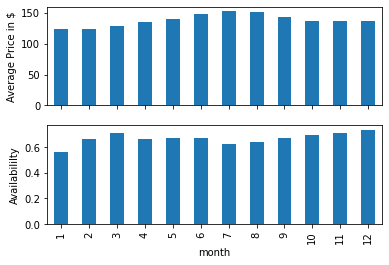

In [26]:
perc_available = calendar_df[['month','available']].groupby('month').aggregate(np.mean)
price_available = calendar_df[calendar_df['available']==True][['month','price']].groupby('month').aggregate(np.mean)

fig,ax = plt.subplots(nrows=2, sharex=True)

price_available.plot.bar(y='price',ax=ax[0],legend=False, ylabel='Average Price in $')
perc_available.plot.bar(y='available',ax=ax[1],legend=False,ylabel='Availabililty')


<AxesSubplot:ylabel='Frequency'>

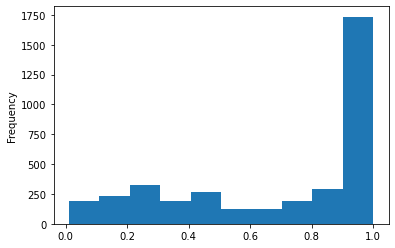

In [27]:
perc_available_per_id = calendar_df[['listing_id','available']].groupby('listing_id').aggregate(np.nanmean)
perc_available_per_id[perc_available_per_id['available'] > 0.01].reset_index()['available'].plot.hist()

In [28]:
perc_available_per_id['available'].idxmin()

107046

### Listings 

In [29]:
listings_df.head()

,id,listing_url,scrape_id,last_scraped,name,summary,space,description,experiences_offered,neighborhood_overview,...,review_scores_value,requires_license,license,jurisdiction_names,instant_bookable,cancellation_policy,require_guest_profile_picture,require_guest_phone_verification,calculated_host_listings_count,reviews_per_month
0,241032,https://www.airbnb.com/rooms/241032,20160104002432,2016-01-04,Stylish Queen Anne Apartment,NaN,Make your self at home in this charming one-be...,Make your self at home in this charming one-be...,none,NaN,...,10.0,f,NaN,WASHINGTON,f,moderate,f,f,2,4.07
1,953595,https://www.airbnb.com/rooms/953595,20160104002432,2016-01-04,Bright & Airy Queen Anne Apartment,Chemically sensitive? We've removed the irrita...,"Beautiful, hypoallergenic apartment in an extr...",Chemically sensitive? We've removed the irrita...,none,"Queen Anne is a wonderful, truly functional vi...",...,10.0,f,NaN,WASHINGTON,f,strict,t,t,6,1.48
2,3308979,https://www.airbnb.com/rooms/3308979,20160104002432,2016-01-04,New Modern House-Amazing water view,New modern house built in 2013. Spectacular s...,"Our house is modern, light and fresh with a wa...",New modern house built in 2013. Spectacular s...,none,Upper Queen Anne is a charming neighborhood fu...,...,10.0,f,NaN,WASHINGTON,f,strict,f,f,2,1.15
3,7421966,https://www.airbnb.com/rooms/7421966,20160104002432,2016-01-04,Queen Anne Chateau,A charming apartment that sits atop Queen Anne...,NaN,A charming apartment that sits atop Queen Anne...,none,NaN,...,NaN,f,NaN,WASHINGTON,f,flexible,f,f,1,NaN
4,278830,https://www.airbnb.com/rooms/278830,20160104002432,2016-01-04,Charming craftsman 3 bdm house,Cozy family craftman house in beautiful neighb...,Cozy family craftman house in beautiful neighb...,Cozy family craftman house in beautiful neighb...,none,We are in the beautiful neighborhood of Queen ...,...,9.0,f,NaN,WASHINGTON,f,strict,f,f,1,0.89


In [12]:
listings_df.columns

Index(['id', 'listing_url', 'scrape_id', 'last_scraped', 'name', 'summary',
       'space', 'description', 'experiences_offered', 'neighborhood_overview',
       'notes', 'transit', 'thumbnail_url', 'medium_url', 'picture_url',
       'xl_picture_url', 'host_id', 'host_url', 'host_name', 'host_since',
       'host_location', 'host_about', 'host_response_time',
       'host_response_rate', 'host_acceptance_rate', 'host_is_superhost',
       'host_thumbnail_url', 'host_picture_url', 'host_neighbourhood',
       'host_listings_count', 'host_total_listings_count',
       'host_verifications', 'host_has_profile_pic', 'host_identity_verified',
       'street', 'neighbourhood', 'neighbourhood_cleansed',
       'neighbourhood_group_cleansed', 'city', 'state', 'zipcode', 'market',
       'smart_location', 'country_code', 'country', 'latitude', 'longitude',
       'is_location_exact', 'property_type', 'room_type', 'accommodates',
       'bathrooms', 'bedrooms', 'beds', 'bed_type', 'amenities', '

In [13]:
listings_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3818 entries, 0 to 3817
Data columns (total 92 columns):
 #   Column                            Non-Null Count  Dtype  
---  ------                            --------------  -----  
 0   id                                3818 non-null   int64  
 1   listing_url                       3818 non-null   object 
 2   scrape_id                         3818 non-null   int64  
 3   last_scraped                      3818 non-null   object 
 4   name                              3818 non-null   object 
 5   summary                           3641 non-null   object 
 6   space                             3249 non-null   object 
 7   description                       3818 non-null   object 
 8   experiences_offered               3818 non-null   object 
 9   neighborhood_overview             2786 non-null   object 
 10  notes                             2212 non-null   object 
 11  transit                           2884 non-null   object 
 12  thumbn

In [14]:
listings_df.neighbourhood_cleansed.value_counts()

Broadway             397
Belltown             234
Wallingford          167
Fremont              158
Minor                135
                    ... 
Arbor Heights          5
Pinehurst              4
South Beacon Hill      4
South Park             3
Roxhill                2
Name: neighbourhood_cleansed, Length: 87, dtype: int64

### Reviews

In [15]:
reviews_df.head()

,listing_id,id,date,reviewer_id,reviewer_name,comments
0,7202016,38917982,2015-07-19,28943674,Bianca,Cute and cozy place. Perfect location to every...
1,7202016,39087409,2015-07-20,32440555,Frank,Kelly has a great room in a very central locat...
2,7202016,39820030,2015-07-26,37722850,Ian,"Very spacious apartment, and in a great neighb..."
3,7202016,40813543,2015-08-02,33671805,George,Close to Seattle Center and all it has to offe...
4,7202016,41986501,2015-08-10,34959538,Ming,Kelly was a great host and very accommodating ...


In [16]:
reviews_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 84849 entries, 0 to 84848
Data columns (total 6 columns):
 #   Column         Non-Null Count  Dtype 
---  ------         --------------  ----- 
 0   listing_id     84849 non-null  int64 
 1   id             84849 non-null  int64 
 2   date           84849 non-null  object
 3   reviewer_id    84849 non-null  int64 
 4   reviewer_name  84849 non-null  object
 5   comments       84831 non-null  object
dtypes: int64(3), object(3)
memory usage: 3.9+ MB


# Question 1: What are the busiest periods in Seattle?

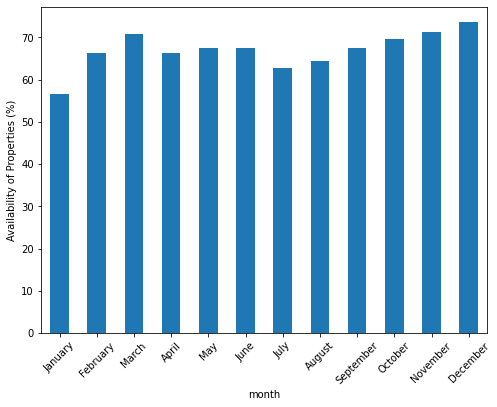

In [32]:
q1 = calendar_df[['month','price','available']].groupby('month').aggregate(np.nanmean)
fig,ax = plt.subplots(figsize=(8,6))
q1['available'] = 100. * q1['available']
q1.plot.bar(y='available',ax=ax,legend=False, ylabel='Availability of Properties (%)')
ax.set_xticklabels(['January','February','March','April', 'May', 'June', 'July', 'August', 'September', 'October', 'November', 'December'])
plt.xticks(rotation=45)
plt.savefig('./AverageAvailibility.png', dpi=400)

In [33]:
q1_geo = calendar_df[['listing_id','month','available']].groupby(['listing_id','month']).aggregate(np.nanmean).reset_index().set_index('listing_id')
q1_geo['neighbourhood_cleansed'] = ''

ids = np.unique(q1_geo.index.values)

for l_id in ids:
    nbh = listings_df[listings_df['id'] == l_id]['neighbourhood_cleansed']
    nbh_geometry = neighbourhoods_df[neighbourhoods_df['neighbourhood'] == nbh.values[0]]['geometry'].values[0]
    q1_geo.loc[lambda x: x.index == l_id,['neighbourhood_cleansed']] = nbh.values[0]


In [34]:
q1_geo = q1_geo.groupby(['month','neighbourhood_cleansed']).aggregate(np.nanmean).reset_index()
q1_geo
# q1_geo['geometry'] = ''

,month,neighbourhood_cleansed,available
0,1,Adams,0.559524
1,1,Alki,0.690476
2,1,Arbor Heights,0.580000
3,1,Atlantic,0.466667
4,1,Belltown,0.597151
...,...,...,...
1039,12,West Woodland,0.748488
1040,12,Westlake,0.732448
1041,12,Whittier Heights,0.807692
1042,12,Windermere,0.751613


In [35]:
months = list(calendar.month_name)
nbh_df = neighbourhoods_df.copy()
tt = listings_df.neighbourhood_cleansed.value_counts()




for mm in np.unique(q1_geo.month.values):
    nbh_df[f'{months[mm]}_av'] = np.nan

nbh_df = nbh_df.set_index('neighbourhood')
nbh_df['listing_count'] = np.nan

tcount = listings_df.neighbourhood_cleansed.value_counts()


for _nnb in np.unique(q1_geo['neighbourhood_cleansed'].values):
    for mm in np.unique(q1_geo.month.values):
        nbh_df.loc[lambda x: x.index == _nnb , [f'{months[mm]}_av']] = q1_geo[((q1_geo['neighbourhood_cleansed'] == _nnb) & (q1_geo['month'] == mm))]['available'].values[0]
        nbh_df.loc[lambda x: x.index == _nnb , ['listing_count']] = tt[_nnb]
        

    
    
    
nbh_df = nbh_df.reset_index()

In [58]:
nbh_df.explore(column='listing_count',legend=True, 
               popup = True, 
               tooltip=["neighbourhood","listing_count"], 
               legend_kwds={'label':'Number of listings','orientation':'horizontal'}, 
               cmap='viridis')

KeyError: 'listing_count'

## Filtering the data based on number of listings within neighbourhood 

In [36]:
def show_filtered(nbh_df, min_listings=0):
    fig,ax = plt.subplots(ncols=2)

    divider_1 = make_axes_locatable(ax[0])
    divider_2 = make_axes_locatable(ax[1])

    cax_1 = divider_1.append_axes("bottom", size="3%", pad=0.3)
    cax_2 = divider_2.append_axes("bottom", size="3%", pad=0.3)


    tt = listings_df.neighbourhood_cleansed.value_counts()
    _nbh_50 = tt[tt > min_listings].index

    nbh_df_filter = nbh_df[np.isin(nbh_df.neighbourhood, _nbh_50)]

    nbh_df_filter.plot(column='January_av',legend=True, 
                legend_kwds={'label':'Average availability in January','orientation':'horizontal'}, 
                ax=ax[0],cax=cax_1, cmap='Blues_r')
    nbh_df_filter.plot(column='July_av',legend=True, 
                legend_kwds={'label':'Average availability in July','orientation':'horizontal'}, 
                ax=ax[1], cax=cax_2, cmap='Reds_r')
    
    best_in_jan = nbh_df_filter.iloc[np.argmin(nbh_df_filter.January_av)]
    best_in_july = nbh_df_filter.iloc[np.argmin(nbh_df_filter.July_av)]
    
    print(f'When we drop neighbourhoods with less then {min_listings} listings:')
    print(f'Least available neighbourhood in January: {best_in_jan.neighbourhood}, {100*best_in_jan.January_av}%')
    print(f'Least available neighbourhood in July: {best_in_july.neighbourhood}, {100*best_in_jan.July_av}%')
    
    
    

When we drop neighbourhoods with less then 20 listings:
Least available neighbourhood in January: South Lake Union, 37.77777777777778%
Least available neighbourhood in July: South Lake Union, 32.97491039426523%


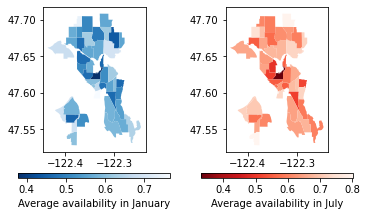

In [37]:
show_filtered(nbh_df, min_listings=20)

## Interactive Mapping

In [38]:
nbh_df.explore(
     column="January_av", # make choropleth based on "BoroName" column
     tooltip=["neighbourhood","January_av","July_av"], # show "January_av" value in tooltip (on hover)
     popup=True, # show all values in popup (on click)
     tiles="CartoDB positron", # use "CartoDB positron" tiles
     cmap="Blues_r", # use "Set1" matplotlib colormap
     style_kwds=dict(color="black"), # use black outline
     name = 'a',
     legend = False
    )

In [ ]:
base = nbh_df.plot(color='white', edgecolor='black')
july_layer = nbh_df[nbh_df.neighbourhood == nbh_df.iloc[np.argmin(nbh_df.July_av)].neighbourhood].plot(color='orange',ax=base)
january_layer = nbh_df[nbh_df.neighbourhood == nbh_df.iloc[np.argmin(nbh_df.January_av)].neighbourhood].plot(color='b',ax=base)


In [ ]:
from mpl_toolkits.axes_grid1 import make_axes_locatable

fig,ax = plt.subplots(ncols=2)

divider_1 = make_axes_locatable(ax[0])
divider_2 = make_axes_locatable(ax[1])

cax_1 = divider_1.append_axes("bottom", size="3%", pad=0.3)
cax_2 = divider_2.append_axes("bottom", size="3%", pad=0.3)



nbh_df_50.plot(column='January_av',legend=True, 
            legend_kwds={'label':'Average availability in January','orientation':'horizontal'}, 
            ax=ax[0],cax=cax_1, cmap='Blues_r')
nbh_df_50.plot(column='July_av',legend=True, 
            legend_kwds={'label':'Average availability in July','orientation':'horizontal'}, 
            ax=ax[1], cax=cax_2, cmap='Reds_r')

fig.tight_layout()

In [ ]:
base = nbh_df.plot(color='white', edgecolor='black')
july_layer = nbh_df_50[nbh_df_50.neighbourhood == nbh_df_50.iloc[np.argmin(nbh_df_50.July_av)].neighbourhood].plot(color='orange',ax=base)
january_layer = nbh_df_50[nbh_df_50.neighbourhood == nbh_df_50.iloc[np.argmin(nbh_df_50.January_av)].neighbourhood].plot(color='b',ax=base)


In [ ]:
gg = sns.FacetGrid(data=q1_geo[np.isin(q1_geo.neighbourhood_cleansed,['Broadway','South Beacon Hill', 'South Lake Union'])], 
                   hue='neighbourhood_cleansed', despine=False)

gg.map(plt.plot,'month','available', marker='o')

In [ ]:
listings_df.neighbourhood_cleansed.value_counts().median()

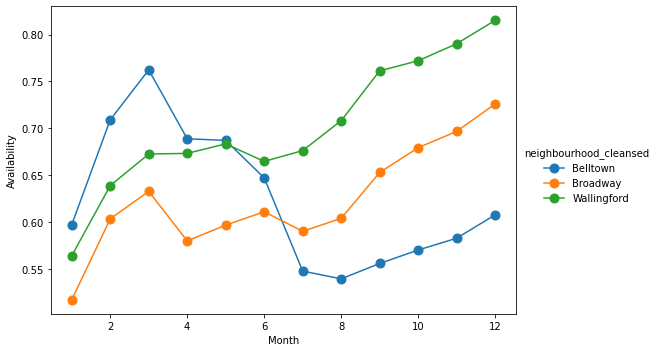

In [30]:
# Plot three biggest 
gg = sns.FacetGrid(data=q1_geo[np.isin(q1_geo.neighbourhood_cleansed,tt[0:3].index)], 
                   hue='neighbourhood_cleansed', 
                   despine=False, 
                   height=5, aspect=1.5, 
                   legend_out=True)

gg.map(plt.plot,'month','available', marker='o', markersize=9)
gg.add_legend()
gg.set_xlabels('Month')
gg.set_ylabels('Availability')


# Question 2: What are average prices of properties? 

(array([ 0,  1,  2,  3,  4,  5,  6,  7,  8,  9, 10, 11]),
 [Text(0, 0, 'January'),
  Text(1, 0, 'February'),
  Text(2, 0, 'March'),
  Text(3, 0, 'April'),
  Text(4, 0, 'May'),
  Text(5, 0, 'June'),
  Text(6, 0, 'July'),
  Text(7, 0, 'August'),
  Text(8, 0, 'September'),
  Text(9, 0, 'October'),
  Text(10, 0, 'November'),
  Text(11, 0, 'December')])

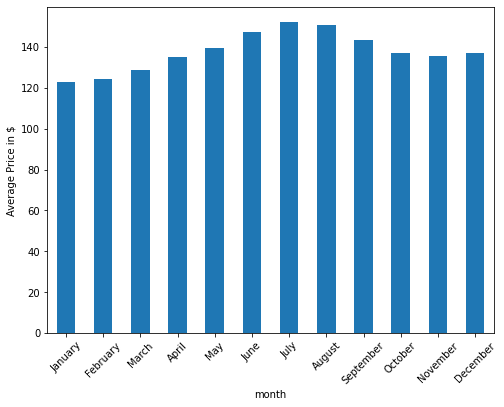

In [39]:
q2 = calendar_df[['month','price','available']].groupby('month').aggregate(np.nanmean)
fig,ax = plt.subplots(figsize=(8,6))
q2.plot.bar(y='price',ax=ax,legend=False, ylabel='Average Price in $')
ax.set_xticklabels(['January','February','March','April', 'May', 'June', 'July', 'August', 'September', 'October', 'November', 'December'])
plt.xticks(rotation=45)

In [41]:
q2_geo = calendar_df[['listing_id','month','price']].groupby(['listing_id','month']).aggregate(np.nanmean).reset_index().set_index('listing_id')
q2_geo['neighbourhood_cleansed'] = ''

ids = np.unique(q2_geo.index.values)

for l_id in ids:
    nbh = listings_df[listings_df['id'] == l_id]['neighbourhood_cleansed']
    nbh_geometry = neighbourhoods_df[neighbourhoods_df['neighbourhood'] == nbh.values[0]]['geometry'].values[0]
    q2_geo.loc[lambda x: x.index == l_id,['neighbourhood_cleansed']] = nbh.values[0]

    
q2_geo = q2_geo.groupby(['month','neighbourhood_cleansed']).aggregate(np.nanmean).reset_index()
q2_geo



,month,neighbourhood_cleansed,price
0,1,Adams,114.909739
1,1,Alki,171.210019
2,1,Arbor Heights,126.800000
3,1,Atlantic,108.677114
4,1,Belltown,150.395667
...,...,...,...
1039,12,West Woodland,135.223118
1040,12,Westlake,211.553350
1041,12,Whittier Heights,128.370200
1042,12,Windermere,263.524194


In [45]:
q2_geo['price'].sort_values()

1026     49.000000
765      60.000000
852      60.000000
678      60.000000
591      60.000000
           ...    
526     262.533778
955     263.000000
694     263.059140
1042    263.524194
781     263.583333
Name: price, Length: 1044, dtype: float64

In [42]:
nbh_df = neighbourhoods_df.copy()



nbh_df = nbh_df.set_index('neighbourhood')



for mm in np.unique(q2_geo.month.values):
    nbh_df[f'{months[mm]}_price'] = np.nan



for _nnb in np.unique(q2_geo['neighbourhood_cleansed'].values):
    for mm in np.unique(q2_geo.month.values):
        nbh_df.loc[lambda x: x.index == _nnb , [f'{months[mm]}_price']] = q2_geo[((q2_geo['neighbourhood_cleansed'] == _nnb) & (q2_geo['month'] == mm))]['price'].values[0]
   
    
# nbh_df = nbh_df.reset_index()

In [47]:
nbh_df['July_price'].sort_values()

neighbourhood
South Beacon Hill      60.000000
Olympic Hills          78.909091
Georgetown             80.430307
South Delridge         80.462366
Victory Heights        82.779570
                         ...    
Southeast Magnolia    254.601613
Belltown              262.533778
Harbor Island                NaN
Rainier View                 NaN
Sand Point                   NaN
Name: July_price, Length: 91, dtype: float64

In [44]:
nbh_df.explore(column='July_price',legend=True, 
               popup = True, 
               tooltip=["neighbourhood","January_price","July_price"], 
               legend_kwds={'label':'July_price','orientation':'horizontal'}, 
               cmap='viridis')

# Question 3: Price prediction 

In [3]:
listings_df[listings_df['id'] == 241032]['price']

0    $85.00
Name: price, dtype: object

In [4]:
listings_df.info()


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3818 entries, 0 to 3817
Data columns (total 92 columns):
 #   Column                            Non-Null Count  Dtype  
---  ------                            --------------  -----  
 0   id                                3818 non-null   int64  
 1   listing_url                       3818 non-null   object 
 2   scrape_id                         3818 non-null   int64  
 3   last_scraped                      3818 non-null   object 
 4   name                              3818 non-null   object 
 5   summary                           3641 non-null   object 
 6   space                             3249 non-null   object 
 7   description                       3818 non-null   object 
 8   experiences_offered               3818 non-null   object 
 9   neighborhood_overview             2786 non-null   object 
 10  notes                             2212 non-null   object 
 11  transit                           2884 non-null   object 
 12  thumbn

In [5]:
listings_df['security_deposit']

0             NaN
1         $100.00
2       $1,000.00
3             NaN
4         $700.00
          ...    
3813          NaN
3814      $500.00
3815      $250.00
3816      $300.00
3817          NaN
Name: security_deposit, Length: 3818, dtype: object

## Data Wrangling and Preparation for Question 3 

In [6]:
# Clean up pricing data from object --> float

# Impute median values for the listings without info, this will be done later in the pipeline

listing_cleanup = listings_df.copy()

cleanup_kwds = ['price', 'cleaning_fee', 'security_deposit']
for kk in cleanup_kwds:
    listing_cleanup[kk] = listing_cleanup[kk].apply( lambda x: np.float32(x.replace(',','').split('$')[1]) if type(x) == str else x )



In [7]:
features_dict = {
    'numerical': ['bathrooms', 'bedrooms', 'beds', 'cleaning_fee', 'review_scores_rating', 'minimum_nights'],
    'categorical': ['property_type', 'neighbourhood_cleansed']
}


In [8]:
# there is better way to do this
import itertools

tot_feat = []
for kk,vv in features_dict.items():
    tot_feat.append(vv)
tot_feat.append(['price'])
flat_ls = list(itertools.chain(*tot_feat))

Xy = listing_cleanup.loc[:,flat_ls]

In [9]:
Xy.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3818 entries, 0 to 3817
Data columns (total 9 columns):
 #   Column                  Non-Null Count  Dtype  
---  ------                  --------------  -----  
 0   bathrooms               3802 non-null   float64
 1   bedrooms                3812 non-null   float64
 2   beds                    3817 non-null   float64
 3   cleaning_fee            2788 non-null   float64
 4   review_scores_rating    3171 non-null   float64
 5   minimum_nights          3818 non-null   int64  
 6   property_type           3817 non-null   object 
 7   neighbourhood_cleansed  3818 non-null   object 
 8   price                   3818 non-null   float32
dtypes: float32(1), float64(5), int64(1), object(2)
memory usage: 253.7+ KB


## Prepare Pipeline

In [10]:
from sklearn.compose import ColumnTransformer
from sklearn.datasets import fetch_openml
from sklearn.pipeline import Pipeline
from sklearn.impute import SimpleImputer
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.linear_model import LogisticRegression
from sklearn.svm import SVR
from sklearn.model_selection import train_test_split, GridSearchCV

In [11]:
# y = Xy.iloc[:,["price"]]
y = Xy['price'].copy()
X = Xy.drop(['price'],axis=1)

In [12]:
# Show the features used
X.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3818 entries, 0 to 3817
Data columns (total 8 columns):
 #   Column                  Non-Null Count  Dtype  
---  ------                  --------------  -----  
 0   bathrooms               3802 non-null   float64
 1   bedrooms                3812 non-null   float64
 2   beds                    3817 non-null   float64
 3   cleaning_fee            2788 non-null   float64
 4   review_scores_rating    3171 non-null   float64
 5   minimum_nights          3818 non-null   int64  
 6   property_type           3817 non-null   object 
 7   neighbourhood_cleansed  3818 non-null   object 
dtypes: float64(5), int64(1), object(2)
memory usage: 238.8+ KB


In [18]:
# Split the data set in train and test
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42)


# Specify transformers
# For numerical features, impute data with median
numeric_transformer = Pipeline(
    steps=[("imputer", SimpleImputer(strategy="median")), ("scaler", StandardScaler())]
)
# For categorical values, use OneHotEncoder
categorical_transformer = OneHotEncoder(handle_unknown="ignore")

# Chain the transformation for full preprocessing
preprocessor = ColumnTransformer(transformers=[
    ("numerical", numeric_transformer, features_dict['numerical']),
    ("categorical", categorical_transformer, features_dict['categorical'] )
])

# Create pipeline - preprocess + SupportVectorRegression
pipeline_svm = Pipeline(steps = [
    ("preprocessor", preprocessor), ("svm", SVR(C=1, gamma="auto", epsilon=10))
])

# Do a grid search with cross-validation

## Define the grid
param_grid = {
    "svm__C": np.logspace(0,3,11),
    "svm__kernel": ['linear', 'rbf']
}

## Define the grid search
grid_search = GridSearchCV(pipeline_svm, param_grid, cv=5, verbose=2)



## Modeling 

In [19]:
grid_search.fit(X_train, y_train)

Fitting 5 folds for each of 22 candidates, totalling 110 fits
[CV] END .....................svm__C=1.0, svm__kernel=linear; total time=   0.2s
[CV] END .....................svm__C=1.0, svm__kernel=linear; total time=   0.1s
[CV] END .....................svm__C=1.0, svm__kernel=linear; total time=   0.1s
[CV] END .....................svm__C=1.0, svm__kernel=linear; total time=   0.1s
[CV] END .....................svm__C=1.0, svm__kernel=linear; total time=   0.1s
[CV] END ........................svm__C=1.0, svm__kernel=rbf; total time=   0.2s
[CV] END ........................svm__C=1.0, svm__kernel=rbf; total time=   0.2s
[CV] END ........................svm__C=1.0, svm__kernel=rbf; total time=   0.2s
[CV] END ........................svm__C=1.0, svm__kernel=rbf; total time=   0.2s
[CV] END ........................svm__C=1.0, svm__kernel=rbf; total time=   0.2s
[CV] END ......svm__C=1.9952623149688795, svm__kernel=linear; total time=   0.1s
[CV] END ......svm__C=1.9952623149688795, svm__

[CV] END ..................svm__C=1000.0, svm__kernel=linear; total time=   9.9s
[CV] END ..................svm__C=1000.0, svm__kernel=linear; total time=  16.0s
[CV] END ..................svm__C=1000.0, svm__kernel=linear; total time=  27.7s
[CV] END ..................svm__C=1000.0, svm__kernel=linear; total time=  10.2s
[CV] END .....................svm__C=1000.0, svm__kernel=rbf; total time=   0.4s
[CV] END .....................svm__C=1000.0, svm__kernel=rbf; total time=   0.4s
[CV] END .....................svm__C=1000.0, svm__kernel=rbf; total time=   0.5s
[CV] END .....................svm__C=1000.0, svm__kernel=rbf; total time=   0.3s
[CV] END .....................svm__C=1000.0, svm__kernel=rbf; total time=   0.3s


GridSearchCV(cv=5,
             estimator=Pipeline(steps=[('preprocessor',
                                        ColumnTransformer(transformers=[('numerical',
                                                                         Pipeline(steps=[('imputer',
                                                                                          SimpleImputer(strategy='median')),
                                                                                         ('scaler',
                                                                                          StandardScaler())]),
                                                                         ['bathrooms',
                                                                          'bedrooms',
                                                                          'beds',
                                                                          'cleaning_fee',
                                                         

In [24]:
grid_search.best_estimator_

Pipeline(steps=[('preprocessor',
                 ColumnTransformer(transformers=[('numerical',
                                                  Pipeline(steps=[('imputer',
                                                                   SimpleImputer(strategy='median')),
                                                                  ('scaler',
                                                                   StandardScaler())]),
                                                  ['bathrooms', 'bedrooms',
                                                   'beds', 'cleaning_fee',
                                                   'review_scores_rating',
                                                   'minimum_nights']),
                                                 ('categorical',
                                                  OneHotEncoder(handle_unknown='ignore'),
                                                  ['property_type',
                                       

In [21]:
(np.abs(y_test - grid_search.best_estimator_.predict(X_test)))

2562     35.415556
1425     54.397942
2186     20.018512
3494      8.874811
3046     37.587181
           ...    
282      12.015373
1736     62.311090
1200    225.044241
1288     88.546778
3622     52.075544
Name: price, Length: 1146, dtype: float64

## Visualize and evaluate results

Text(0, 0.5, 'Price difference (estimated - test) $')

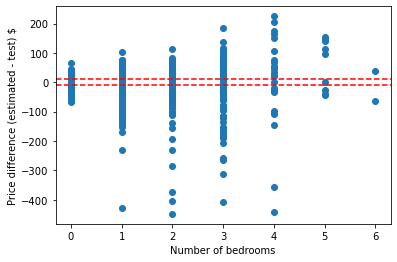

In [22]:
plt.plot(X_test['bedrooms'],grid_search.best_estimator_.predict(X_test)-y_test,ls='None', marker='o')
plt.axhline(10,ls='--',c='r')
plt.axhline(-10,ls='--',c='r')

plt.xlabel('Number of bedrooms')
plt.ylabel('Price difference (estimated - test) $')


(array([544., 323., 131.,  52.,  34.,  18.,  11.,  10.,   6.,   3.,   3.,
          0.,   2.,   1.,   1.,   0.,   1.,   1.,   1.,   2.,   2.]),
 array([3.94007501e-02, 2.13904070e+01, 4.27414132e+01, 6.40924194e+01,
        8.54434256e+01, 1.06794432e+02, 1.28145438e+02, 1.49496444e+02,
        1.70847450e+02, 1.92198457e+02, 2.13549463e+02, 2.34900469e+02,
        2.56251475e+02, 2.77602482e+02, 2.98953488e+02, 3.20304494e+02,
        3.41655500e+02, 3.63006506e+02, 3.84357513e+02, 4.05708519e+02,
        4.27059525e+02, 4.48410531e+02]),
 <BarContainer object of 21 artists>)

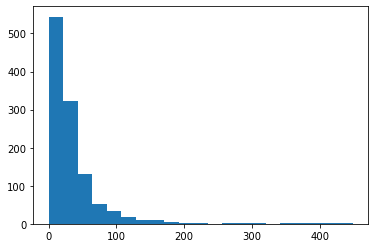

In [25]:
plt.hist(abs(y_test - grid_search.best_estimator_.predict(X_test)),bins=21)

Text(0.5, 0, 'Price difference')

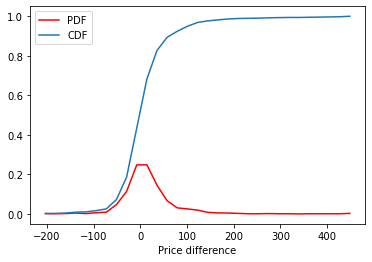

In [40]:
diff_data = y_test - grid_search.best_estimator_.predict(X_test)
count, bins_count = np.histogram(diff_data, bins=31)
pdf = count / np.sum(count)
cdf = np.cumsum(pdf)

plt.plot(bins_count[1:], pdf, color="red", label="PDF")
plt.plot(bins_count[1:], cdf, label="CDF")
plt.legend()

plt.xlabel('Price difference')

In [42]:
# Estimate percentage of cases within +/- 30#
sum(pdf[((bins_count[1:] > -30) & (bins_count[1:] < 30))])

0.6099476439790577